In [6]:
!nvidia-smi --query-gpu=name --format=csv,noheader
!date

Tesla V100-SXM2-16GB
Sun Jul  4 16:52:07 UTC 2021


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DBSCAN python sklearn performance

In [8]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
import multiprocessing

In [9]:
eps = 4
minpts = 5

n, d = 400000, 20

X, y = make_blobs(n_samples=n, n_features=d, shuffle=True, random_state=None, centers=20)
print(X.shape)

np.savetxt('/content/drive/MyDrive/G-DBSCAN/data.txt', X.flatten(order='F'), fmt='%f', header=f'{X.shape[0]} {X.shape[1]} {eps} {minpts}')

(400000, 20)


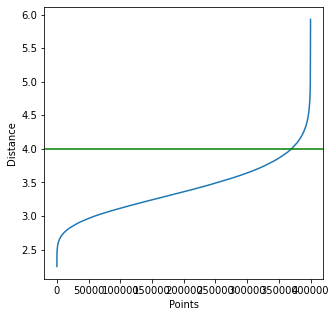

In [10]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=minpts+1)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,minpts], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.axhline(eps, color='green')

plt.show()

In [11]:
#plt.scatter(X[:, 0], X[:, 1], c=y)
#plt.show()

In [12]:
t0 = time.perf_counter()
clustering = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1, algorithm='brute').fit(X)
python_time = time.perf_counter() - t0
print(f'Elapsed time {python_time}s with {multiprocessing.cpu_count()} cpu')

Elapsed time 2770.6097283699996s with 2 cpu


In [13]:
#plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_)
#plt.show()

In [14]:
metrics.adjusted_rand_score(y, clustering.labels_), metrics.adjusted_rand_score(y, y)

(0.9775476898710891, 1.0)

In [15]:
%cd /content/drive/MyDrive/G-DBSCAN
!nvcc --generate-line-info -arch=sm_70 gdbscan.cu
!nvcc -arch=sm_70 gdbscan.cu -o perf.out
!time ./perf.out data.txt > standard_perf_time
!cat standard_perf_time

!nvcc --generate-line-info -arch=sm_70 gdbscan_paper.cu
!nvcc -arch=sm_70 gdbscan_paper.cu -o perf.out
!time ./perf.out data.txt > paper_perf_time
!cat paper_perf_time

!nvcc --generate-line-info -arch=sm_70 gdbscan_shifted.cu
!nvcc -arch=sm_70 gdbscan_shifted.cu -o perf.out
!time ./perf.out data.txt > shifted_perf_time
!cat shifted_perf_time

!nvcc --generate-line-info -arch=sm_70 gdbscan_shared.cu
!nvcc -arch=sm_70 gdbscan_shared.cu -o perf.out
!time ./perf.out data.txt > shared_perf_time
!cat shared_perf_time

/content/drive/MyDrive/G-DBSCAN

real	1m2.971s
user	1m1.540s
sys	0m0.203s
Compute degrees elapsed time               : 29.599 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 29.780 (sec)
BFS elapsed time               : 0.089 (sec)

real	1m2.822s
user	1m1.670s
sys	0m0.244s
Compute degrees elapsed time               : 29.608 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 29.772 (sec)
BFS elapsed time               : 0.424 (sec)

real	1m4.015s
user	1m3.082s
sys	0m0.215s
Compute degrees elapsed time               : 30.481 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 30.640 (sec)
BFS elapsed time               : 0.081 (sec)

real	1m6.137s
user	1m4.539s
sys	0m0.207s
Compute degrees elapsed time               : 30.078 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time   

# Test and profiling CUDA Implementation

Compiles and profiles standard implementation

In [ ]:
%cd /content/drive/MyDrive/G-DBSCAN
!nvcc --generate-line-info -arch=sm_70 gdbscan.cu
!nvcc -arch=sm_70 gdbscan.cu -o perf.out

!wc -l data.txt
!time ./perf.out data.txt > standard_perf_time
!cat standard_perf_time
!ncu --kernel-name compute_degrees --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > standard_computedegrees.csv
!ncu --kernel-name compute_adjacency_list --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > standard_computeadjlist.csv
!ncu --kernel-name cluster_assignment --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > standard_clusterassignment.csv
!ncu --kernel-name kernel_bfs --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > standard_kernelbfs.csv

/content/drive/MyDrive/G-DBSCAN
2000001 data.txt

real	0m9.544s
user	0m9.342s
sys	0m0.156s
Compute degrees elapsed time               : 4.395 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 4.411 (sec)
BFS elapsed time               : 0.056 (sec)


In [19]:
cuda_labels = np.loadtxt("out.txt", dtype=np.int32)
metrics.adjusted_rand_score(y, cuda_labels ), metrics.adjusted_rand_score(clustering.labels_, cuda_labels)
#plt.scatter(X[:, 0], X[:, 1], c=cuda_labels)
#plt.show()

(0.9778261076897966, 0.9997125808726197)

Compiles and profiles paper implementation

In [ ]:
%cd /content/drive/MyDrive/G-DBSCAN
!nvcc --generate-line-info -arch=sm_70 gdbscan_paper.cu
!nvcc -arch=sm_70 gdbscan_paper.cu -o perf.out

!time ./perf.out data.txt > paper_perf_time
!cat paper_perf_time
!ncu --kernel-name compute_degrees --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > paper_computedegrees.csv
!ncu --kernel-name compute_adjacency_list --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > paper_computeadjlist.csv
!ncu --kernel-name cluster_assignment --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > paper_clusterassignment.csv
!ncu --kernel-name kernel_bfs --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > paper_kernelbfs.csv

/content/drive/MyDrive/G-DBSCAN

real	0m10.228s
user	0m9.570s
sys	0m0.179s
Compute degrees elapsed time               : 4.395 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 4.411 (sec)
BFS elapsed time               : 0.313 (sec)


In [16]:
cuda_labels = np.loadtxt("out_paper.txt", dtype=np.int32)
metrics.adjusted_rand_score(y, cuda_labels ), metrics.adjusted_rand_score(clustering.labels_, cuda_labels)
#plt.scatter(X[:, 0], X[:, 1], c=cuda_labels)
#plt.show()

(0.9778261076897966, 0.9997125808726197)

Compiles and profiles shifted memory access implementation

In [ ]:
%cd /content/drive/MyDrive/G-DBSCAN
!nvcc --generate-line-info -arch=sm_70 gdbscan_shifted.cu
!nvcc -arch=sm_70 gdbscan_shifted.cu -o perf.out

!time ./perf.out data.txt > shifted_perf_time
!cat shifted_perf_time
!ncu --kernel-name compute_degrees --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shifted_computedegrees.csv
!ncu --kernel-name compute_adjacency_list --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shifted_computeadjlist.csv
!ncu --kernel-name cluster_assignment --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shifted_clusterassignment.csv
!ncu --kernel-name kernel_bfs --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shifted_kernelbfs.csv

/content/drive/MyDrive/G-DBSCAN

real	0m9.773s
user	0m9.563s
sys	0m0.162s
Compute degrees elapsed time               : 4.494 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 4.535 (sec)
BFS elapsed time               : 0.060 (sec)


In [17]:
cuda_labels = np.loadtxt("out_shifted.txt", dtype=np.int32)
metrics.adjusted_rand_score(y, cuda_labels ), metrics.adjusted_rand_score(clustering.labels_, cuda_labels)
#plt.scatter(X[:, 0], X[:, 1], c=cuda_labels)
#plt.show()

(0.9778261076897966, 0.9997125808726197)

Compiles and profiles shared implementation

In [ ]:
%cd /content/drive/MyDrive/G-DBSCAN
!nvcc --generate-line-info -arch=sm_70 gdbscan_shared.cu
!nvcc -arch=sm_70 gdbscan_shared.cu -o perf.out

!time ./perf.out data.txt > shared_perf_time
!cat shared_perf_time
!ncu --kernel-name compute_degrees --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shared_computedegrees.csv
!ncu --kernel-name compute_adjacency_list --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shared_computeadjlist.csv
!ncu --kernel-name cluster_assignment --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shared_clusterassignment.csv
!ncu --kernel-name kernel_bfs --csv --launch-skip 0 --launch-count 1 --set full "/content/drive/My Drive/G-DBSCAN/./a.out" data.txt > shared_kernelbfs.csv

/content/drive/MyDrive/G-DBSCAN

real	0m11.202s
user	0m8.311s
sys	0m0.260s
Compute degrees elapsed time               : 3.815 (sec)
Exclusive scan elapsed time               : 0.001 (sec)
Compute adj list elapsed time               : 3.956 (sec)
BFS elapsed time               : 0.056 (sec)


In [18]:
cuda_labels = np.loadtxt("out_shared.txt", dtype=np.int32)
metrics.adjusted_rand_score(y, cuda_labels ), metrics.adjusted_rand_score(clustering.labels_, cuda_labels)
#plt.scatter(X[:, 0], X[:, 1], c=cuda_labels)
#plt.show()

(0.9778261076897966, 0.9997125808726197)

Compiles and profiles different grid invocation

In [ ]:
!date

Sun Jul  4 12:33:39 UTC 2021


# Useful code to keep around 

In [ ]:
#!ncu --kernel-name compute_degrees --launch-skip 0 --launch-count 1 --section ComputeWorkloadAnalysis "/content/drive/My Drive/G-DBSCAN/./a.out" ../../../data.txt

In [ ]:
#!ncu --kernel-name compute_degrees --launch-skip 0 --launch-count 1 "/content/drive/My Drive/G-DBSCAN/./a.out" ../../../data.txt

In [ ]:
# To visualize with Nvidia Nsight graphic interface
#!rm *.qdrep
#!nsys profile ./a.out ../../../data.txt

In [ ]:
# Only for debug purposes
#!cuda-memcheck ./a.out data.txt | head -n 100